In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# 1. Define reward distributions
# ==============================

# Number of actions (arms)
k = 10

# Generate true action values q*(a) for each action with varying means and standard deviations
means = np.random.uniform(-5, 5, k)            # Means vary between -2 and 2
std_devs = np.random.uniform(0.5, 3.0, k)      # Standard deviations vary between 0.5 and 2.0

# Generate reward distributions for each action (e.g., 10k samples per arm)
reward_distributions = [
    np.random.normal(mean, std_dev, 10000)
    for mean, std_dev in zip(means, std_devs)
]


/var/folders/23/ycjghqwj3lv5hzqf78_dw32m0000gn/T/ipykernel_1266/390074076.py:10: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.violinplot(data=reward_distributions, scale="width", inner="quartile", palette=colors)
/var/folders/23/ycjghqwj3lv5hzqf78_dw32m0000gn/T/ipykernel_1266/390074076.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=reward_distributions, scale="width", inner="quartile", palette=colors)


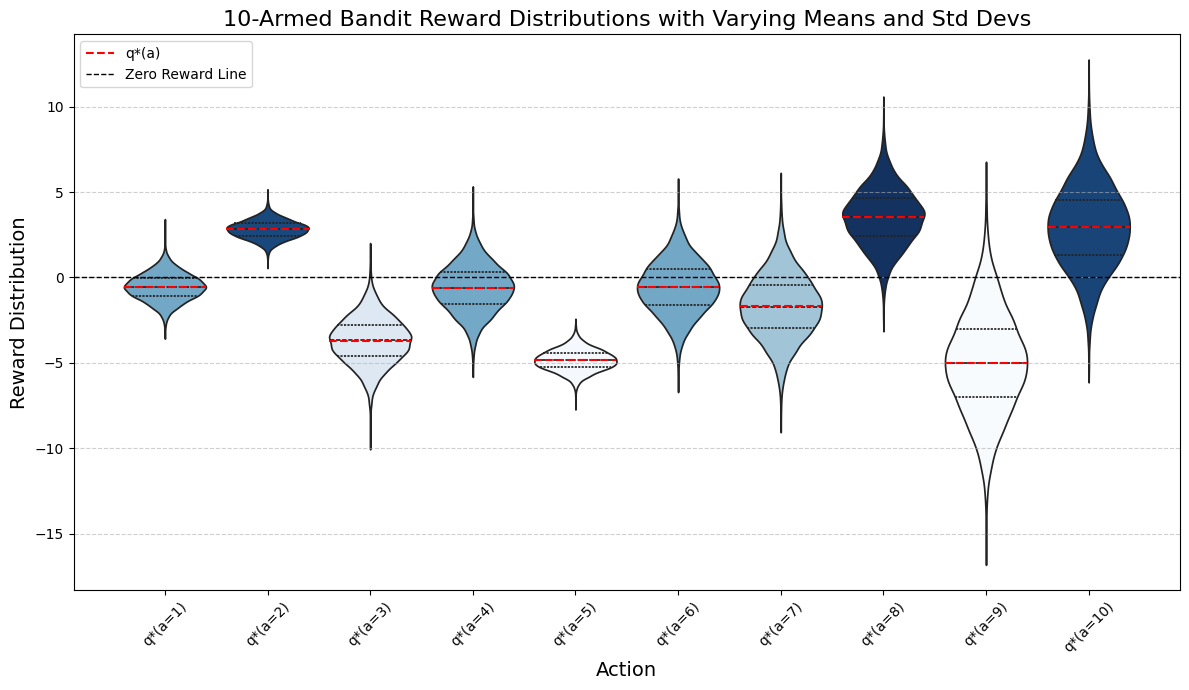

In [19]:
# For visualization: Plot these reward distributions via a violin plot
plt.figure(figsize=(12, 7))

# Calculate a color palette based on the mean values
min_mean, max_mean = np.min(means), np.max(means)
colors = sns.color_palette("Blues", as_cmap=True)(
    (means - min_mean) / (max_mean - min_mean)
)

sns.violinplot(data=reward_distributions, scale="width", inner="quartile", palette=colors)

# Add horizontal red dashed lines indicating each distribution’s mean
for i, mean_val in enumerate(means):
    plt.plot([i - 0.4, i + 0.4], [mean_val, mean_val],
             color="red", linestyle="--", linewidth=1.5,
             label="q*(a)" if i == 0 else "")

plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Reward Line')
plt.xticks(
    ticks=np.arange(k),
    labels=[f"q*(a={i+1})" for i in range(k)],
    rotation=45
)
plt.xlabel("Action", fontsize=14)
plt.ylabel("Reward Distribution", fontsize=14)
plt.title("10-Armed Bandit Reward Distributions with Varying Means and Std Devs", fontsize=16)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [20]:


# ========================================
# 2. Use these distributions in simulation
# ========================================

def run_experiment(epsilon, steps=1000, runs=100):
    """
    Run a k-armed bandit experiment with an epsilon-greedy strategy,
    using the globally-defined 'reward_distributions' instead of
    regenerating new ones.
    """
    average_rewards = np.zeros(steps)
    optimal_action_percents = np.zeros(steps)

    # Identify which action is truly 'optimal' (highest mean) for our fixed distributions
    # We'll consider the arm with the highest mean of its distribution as the optimal.
    means_of_each_arm = [np.mean(dist) for dist in reward_distributions]
    optimal_action = np.argmax(means_of_each_arm)

    for _ in range(runs):
        # Initialize estimated action values and counts
        estimated_action_values = np.zeros(k)
        action_counts = np.zeros(k)

        rewards = []
        optimal_actions = []

        for step in range(steps):
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = np.random.choice(k)  # Explore
            else:
                action = np.argmax(estimated_action_values)  # Exploit

            # Sample the reward from the pre-defined distribution for this action
            reward = np.random.choice(reward_distributions[action])
            rewards.append(reward)

            # Update action-value estimates (sample average method)
            action_counts[action] += 1
            estimated_action_values[action] += (
                (reward - estimated_action_values[action]) / action_counts[action]
            )

            # Track if the optimal action was chosen
            optimal_actions.append(int(action == optimal_action))

        average_rewards += np.array(rewards)
        optimal_action_percents += np.array(optimal_actions)

    # Compute averages over all runs
    average_rewards /= runs
    optimal_action_percents = (optimal_action_percents / runs) * 100

    return average_rewards, optimal_action_percents

# Experiment settings
epsilons = [0, 0.01, 0.1]
steps = 5000
runs = 1000

# Run experiments for each epsilon
results = {epsilon: run_experiment(epsilon, steps=steps, runs=runs) for epsilon in epsilons}


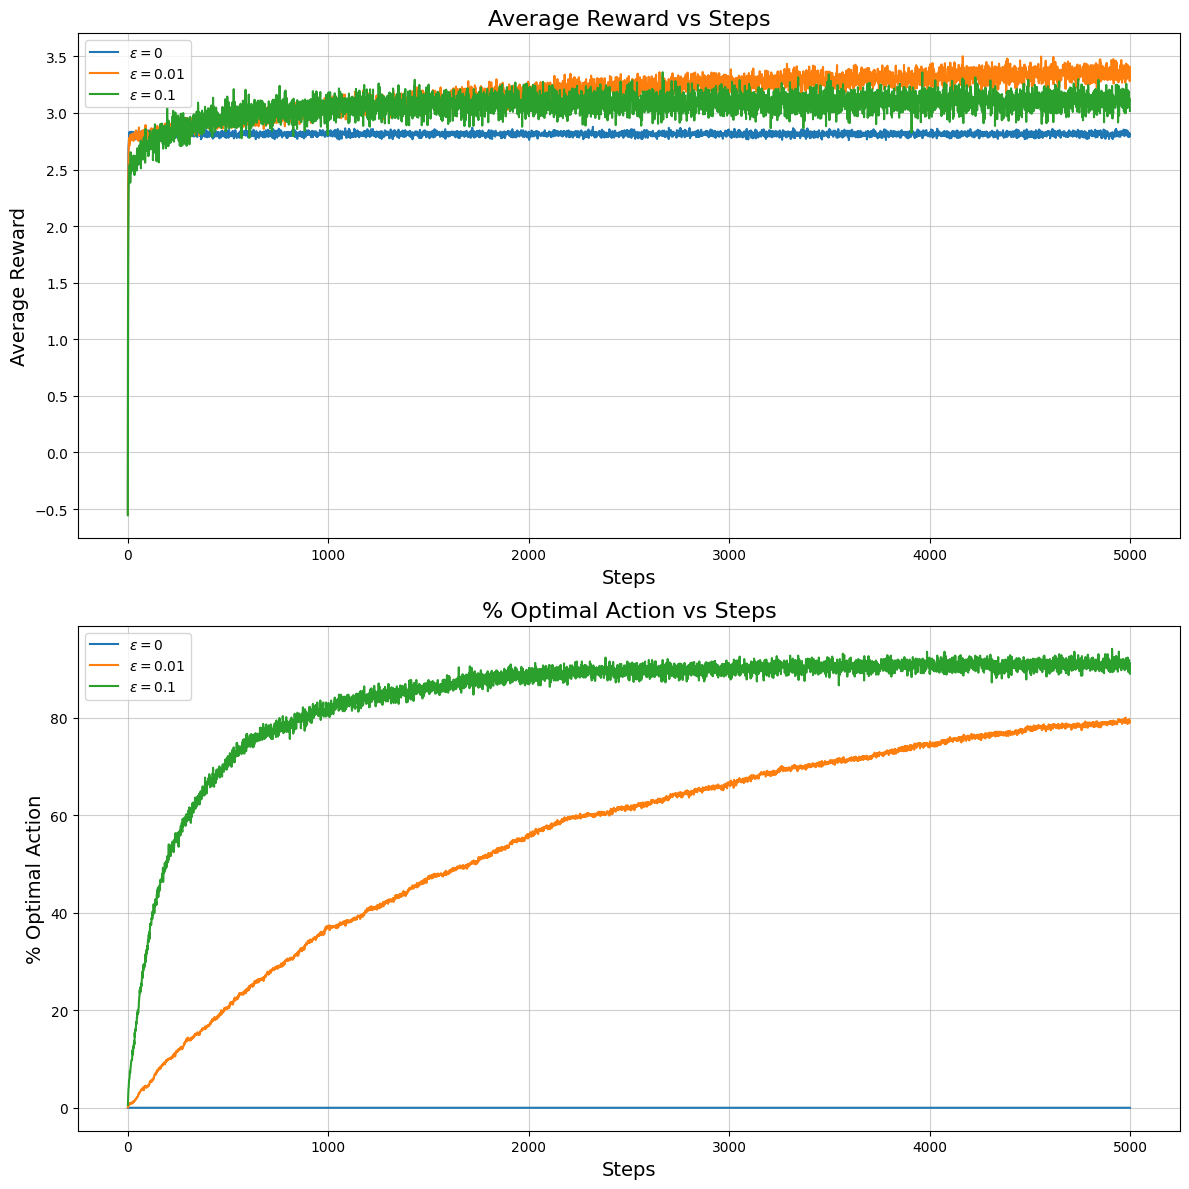

In [21]:

# ==============================
# 3. Plot the simulation results
# ==============================

plt.figure(figsize=(12, 12))

# Plot average reward
plt.subplot(2, 1, 1)
for epsilon, (average_rewards, _) in results.items():
    plt.plot(average_rewards, label=f"$\\epsilon={epsilon}$")
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Average Reward", fontsize=14)
plt.title("Average Reward vs Steps", fontsize=16)
plt.legend()
plt.grid(alpha=0.6)

# Plot % optimal action
plt.subplot(2, 1, 2)
for epsilon, (_, optimal_action_percents) in results.items():
    plt.plot(optimal_action_percents, label=f"$\\epsilon={epsilon}$")
plt.xlabel("Steps", fontsize=14)
plt.ylabel("% Optimal Action", fontsize=14)
plt.title("% Optimal Action vs Steps", fontsize=16)
plt.legend()
plt.grid(alpha=0.6)

plt.tight_layout()
plt.show()


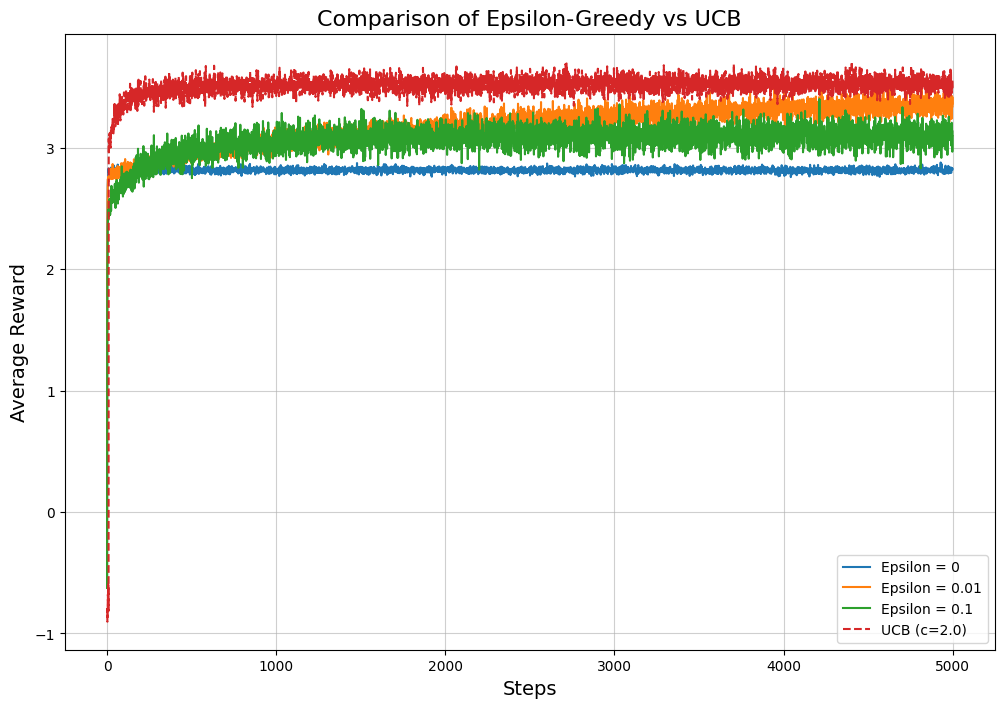

In [22]:
def run_experiment(
    epsilon, 
    steps=1000, 
    runs=100, 
    upb=False,      # <-- New arg: Enable/disable UCB
    ucb_c=2.0       # <-- New arg: c in the UCB formula
):
    """
    Run a k-armed bandit experiment. If upb=True, use the UCB action selection;
    otherwise, use epsilon-greedy.
    """
    average_rewards = np.zeros(steps)
    optimal_action_percents = np.zeros(steps)

    # Identify which action is truly 'optimal' (highest mean) for our fixed distributions
    means_of_each_arm = [np.mean(dist) for dist in reward_distributions]
    optimal_action = np.argmax(means_of_each_arm)

    for _ in range(runs):
        # Initialize estimated action values and counts
        estimated_action_values = np.zeros(k)
        action_counts = np.zeros(k)

        rewards = []
        optimal_actions = []

        for step in range(steps):
            if upb:
                # -------------------------
                # UCB Action Selection
                # -------------------------
                # 1. If there's any action that has not been tried yet (count=0),
                #    pick it first to avoid division by zero and to ensure exploration.
                untried_actions = np.where(action_counts == 0)[0]
                if len(untried_actions) > 0:
                    action = np.random.choice(untried_actions)
                else:
                    # 2. Compute UCB for each action
                    #    Q_t(a) + c * sqrt( ln(step+1) / N(a) )
                    # Use step+1 because t should be at least 1
                    ucb_values = estimated_action_values + ucb_c * np.sqrt(
                        np.log(step + 1) / action_counts
                    )
                    action = np.argmax(ucb_values)
            else:
                # ---------------------------------
                # Epsilon-Greedy Action Selection
                # ---------------------------------
                if np.random.rand() < epsilon:
                    action = np.random.choice(k)  # Explore
                else:
                    action = np.argmax(estimated_action_values)  # Exploit

            # -------------------------
            # Sample reward from chosen arm
            # -------------------------
            reward = np.random.choice(reward_distributions[action])
            rewards.append(reward)

            # -------------------------
            # Update estimates
            # -------------------------
            action_counts[action] += 1
            estimated_action_values[action] += (
                (reward - estimated_action_values[action]) / action_counts[action]
            )

            # Track if the optimal action was chosen
            optimal_actions.append(int(action == optimal_action))

        # Accumulate results over runs
        average_rewards += np.array(rewards)
        optimal_action_percents += np.array(optimal_actions)

    # Compute averages over all runs
    average_rewards /= runs
    optimal_action_percents = (optimal_action_percents / runs) * 100

    return average_rewards, optimal_action_percents


# ============================================
# Example usage (mixing epsilon-greedy and UCB)
# ============================================
epsilons = [0, 0.01, 0.1]
steps = 5000
runs = 1000

# 1) Epsilon-greedy results
results = {epsilon: run_experiment(epsilon, steps=steps, runs=runs, upb=False) 
           for epsilon in epsilons}

# 2) UCB result (with c=2.0, for instance)
ucb_result = run_experiment(epsilon=0, steps=steps, runs=runs, upb=True, ucb_c=2.0)

# Now you can plot results for:
# - Epsilon=0
# - Epsilon=0.01
# - Epsilon=0.1
# - UCB with c=2.0
# etc.

# Example plot
plt.figure(figsize=(12, 8))

# Plot average rewards for e-greedy
for epsilon, (avg_rewards, _) in results.items():
    plt.plot(avg_rewards, label=f"Epsilon = {epsilon}")

# Plot average rewards for UCB
plt.plot(ucb_result[0], label="UCB (c=2.0)", linestyle='--')

plt.xlabel("Steps", fontsize=14)
plt.ylabel("Average Reward", fontsize=14)
plt.title("Comparison of Epsilon-Greedy vs UCB", fontsize=16)
plt.legend()
plt.grid(alpha=0.6)
plt.show()

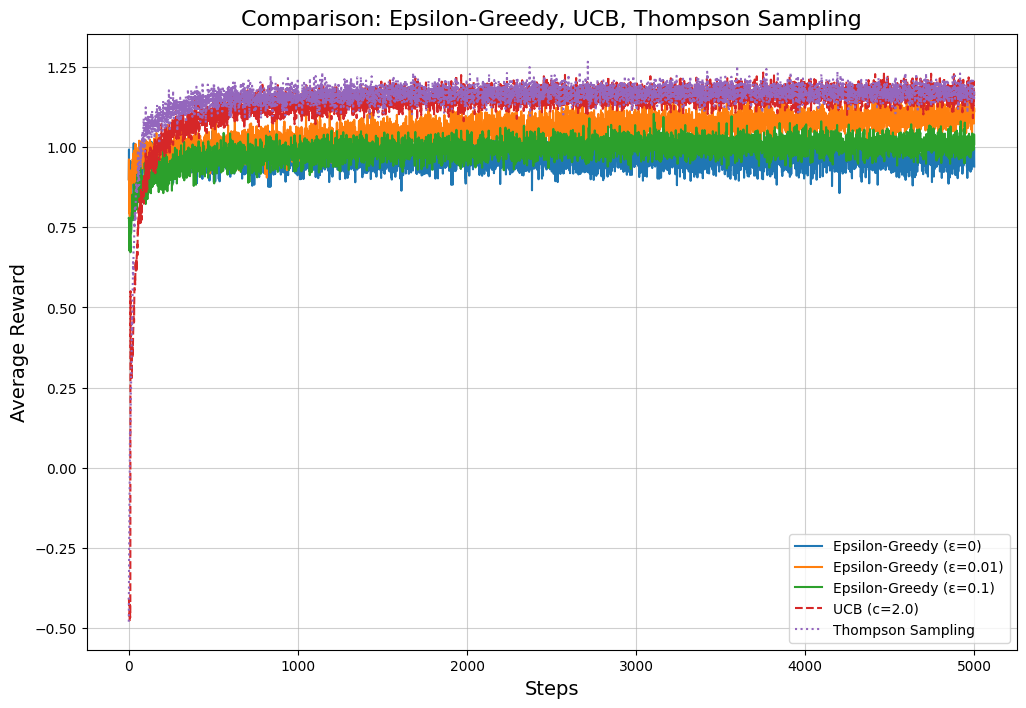

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Number of actions (arms)
k = 10

# Generate true action values q*(a) for each action with varying means and std devs
means = np.random.uniform(-2, 2, k)         # Means vary between -2 and 2
std_devs = np.random.uniform(0.5, 2.0, k)   # Std devs vary between 0.5 and 2.0

# Generate reward distributions for each action (e.g., 10k samples per arm)
reward_distributions = [
    np.random.normal(mean, sd, 10000)
    for mean, sd in zip(means, std_devs)
]

def run_experiment(
    epsilon, 
    steps=1000, 
    runs=100, 
    upb=False,       # Use Upper-Confidence Bound if True
    ucb_c=2.0,       # Exploration parameter for UCB
    thompson=False   # <--- New: Use Thompson Sampling if True
):
    """
    Run a k-armed bandit experiment. Three modes:
    1) Epsilon-greedy    (if upb=False and thompson=False)
    2) UCB               (if upb=True)
    3) Thompson Sampling (if thompson=True)

    Note: if multiple flags (upb, thompson) are True simultaneously,
          the priority is: Thompson > UCB > Epsilon-greedy.
    """
    average_rewards = np.zeros(steps)
    optimal_action_percents = np.zeros(steps)

    # Identify which action is truly 'optimal' (highest mean)
    means_of_each_arm = [np.mean(dist) for dist in reward_distributions]
    optimal_action = np.argmax(means_of_each_arm)

    for _ in range(runs):
        # Initialize estimated action values and counts
        estimated_action_values = np.zeros(k)  # Q_t(a)
        action_counts = np.zeros(k, dtype=int)

        rewards = []
        optimal_actions = []

        for step in range(steps):
            if thompson:
                # -------------------------
                # Thompson Sampling
                # -------------------------
                # If an arm has never been tried, sample from prior ~ N(0,1)
                # else sample from posterior ~ N(estimated_mean, 1/N)
                samples = []
                for a in range(k):
                    if action_counts[a] == 0:
                        # Prior
                        sampled_mean = np.random.normal(0, 1)
                    else:
                        # Posterior
                        sampled_mean = np.random.normal(
                            loc=estimated_action_values[a],
                            scale=np.sqrt(1.0 / action_counts[a])  # simple 1/N model
                        )
                    samples.append(sampled_mean)
                action = np.argmax(samples)

            elif upb:
                # -------------------------
                # UCB Action Selection
                # -------------------------
                untried_actions = np.where(action_counts == 0)[0]
                if len(untried_actions) > 0:
                    # Pull each arm at least once before using UCB formula
                    action = np.random.choice(untried_actions)
                else:
                    ucb_values = estimated_action_values + ucb_c * np.sqrt(
                        np.log(step + 1) / action_counts
                    )
                    action = np.argmax(ucb_values)

            else:
                # -------------------------
                # Epsilon-Greedy
                # -------------------------
                if np.random.rand() < epsilon:
                    action = np.random.choice(k)  # Explore
                else:
                    action = np.argmax(estimated_action_values)  # Exploit

            # -------------------------
            # Sample reward from chosen arm
            # -------------------------
            reward = np.random.choice(reward_distributions[action])
            rewards.append(reward)

            # -------------------------
            # Update action-value estimate
            # -------------------------
            action_counts[action] += 1
            estimated_action_values[action] += (
                (reward - estimated_action_values[action]) / action_counts[action]
            )

            # Track if the optimal action was chosen
            optimal_actions.append(int(action == optimal_action))

        # Accumulate results over runs
        average_rewards += np.array(rewards)
        optimal_action_percents += np.array(optimal_actions)

    # Compute averages over all runs
    average_rewards /= runs
    optimal_action_percents = (optimal_action_percents / runs) * 100

    return average_rewards, optimal_action_percents

# ========================================
# Example usage
# ========================================
if __name__ == "__main__":
    epsilons = [0, 0.01, 0.1]
    steps = 5000
    runs = 3000

    # 1) Epsilon-greedy results
    results_eps = {
        epsilon: run_experiment(epsilon, steps=steps, runs=runs, upb=False, thompson=False)
        for epsilon in epsilons
    }

    # 2) UCB result
    ucb_result = run_experiment(epsilon=0, steps=steps, runs=runs, upb=True, ucb_c=2.0)

    # 3) Thompson Sampling result
    ts_result = run_experiment(epsilon=0, steps=steps, runs=runs, thompson=True)

    # Plot comparisons
    plt.figure(figsize=(12, 8))

    # Plot average rewards for e-greedy
    for epsilon, (avg_rewards, _) in results_eps.items():
        plt.plot(avg_rewards, label=f"Epsilon-Greedy (ε={epsilon})")

    # Plot average rewards for UCB
    plt.plot(ucb_result[0], label="UCB (c=2.0)", linestyle='--')

    # Plot average rewards for Thompson Sampling
    plt.plot(ts_result[0], label="Thompson Sampling", linestyle=':')

    plt.xlabel("Steps", fontsize=14)
    plt.ylabel("Average Reward", fontsize=14)
    plt.title("Comparison: Epsilon-Greedy, UCB, Thompson Sampling", fontsize=16)
    plt.legend()
    plt.grid(alpha=0.6)
    plt.show()
